## Stroke Data

Source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In this notebook I will be using 10 features to predict binary stroke outcomes (1 = stroke, 0 = no stroke). The dataset includes 11 features, but one is a unique identifier (column = 'id') that will be dropped for it adds no benefit to the analysis.

The dataset has 5110 examples, so the following models seem like an appropriate starting point for this binary classification task:
- Logistic Regression 
- Linear Support Vector Machine
- KNeighbors Classifier

Let's get the data and see what we're working with.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [32]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [33]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


A quick glance suggests that bmi is the only feature missing values.

In [35]:
df.shape

(5110, 12)

In [36]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The minimum age (0.08) seems a little fishy for a stroke study. Let's just make sure that nothing else from that feature vector is intuitively false.

In [37]:
df[df.age == df.age.min()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0


the avg_glucose_level for the female is twice that of the male, but it's difficult to assess the goodness given that we don't know the unit of measurement. Otherwise, these results seem reasonable.

### Exploratory Data Analysis

One of the first things to look for when performing binary classification is representation of the minority class. We want to see a somewhat even distribution across classes. 

Let's take at the frequency of our target variable.

<AxesSubplot:xlabel='stroke', ylabel='count'>

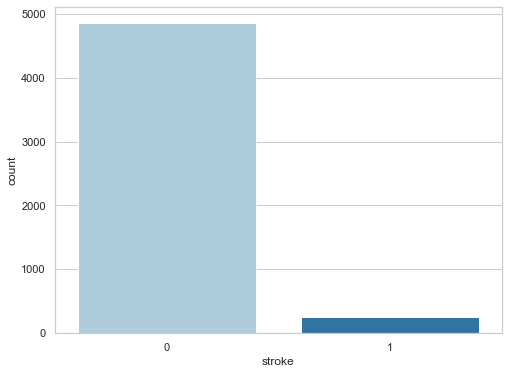

In [38]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,6))
sns.countplot(data=df, x='stroke', palette='Paired')

In [39]:
len(df[df['stroke']==1])

249

In [40]:
(len(df[(df.stroke==1)]) / len(df)) * 100

4.87279843444227

## Yikes!
The minority class, stroke = 1, represents only 4.873% of outcomes (249 occurences). Without further intervention, the imbalance of the target variable will likely result in poor classification results. 

To address the imbalance, we can either undersample the majority class or oversample the minority class. Given how small the dataset is (5110 instances), we will oversample the minority class using the Synthetic Minority Oversampling Technique (SMOTE). 

More on that later.

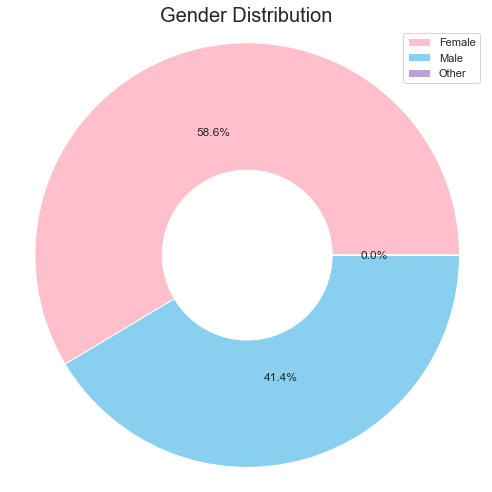

In [41]:
labels = ['Female', 'Male', 'Other']
colors = ['#ffc0cb', '#89cff0', '#bca0dc']


fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(x=df.gender.value_counts(), labels=labels, labeldistance=None, autopct='%1.1f%%', colors=colors)


centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.legend()
ax1.axis('equal')
plt.title('Gender Distribution', fontsize='20')
plt.tight_layout()
plt.show()

In [42]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

We'll eliminate the feature vector that includes the lone 'Other' gender instance to keep things tidy--otherwise encoding would results in 2 features rather than 1--and because removing it should have little effect.

##### Let's now check the gender distribution for instances where stroke=1.

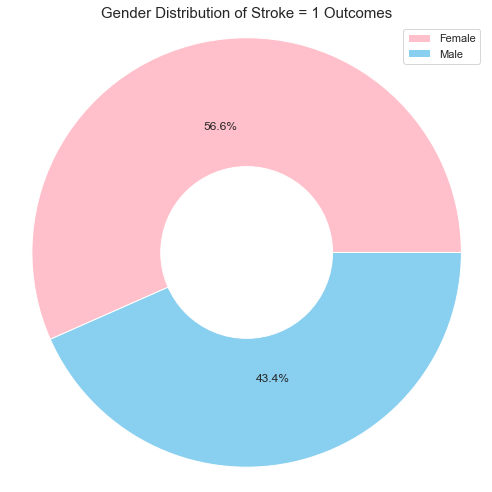

In [43]:
labels = ['Female', 'Male']
colors = ['#ffc0cb', '#89cff0']


fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(x=df[df.stroke==1].gender.value_counts(), labels=labels, labeldistance=None, autopct='%1.1f%%', colors=colors)


centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.legend()
ax1.axis('equal')
plt.title('Gender Distribution of Stroke = 1 Outcomes', fontsize='15')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='gender', ylabel='count'>

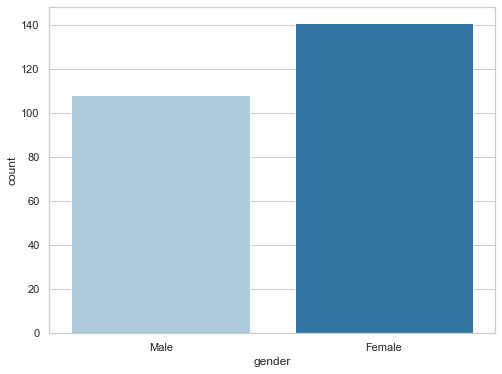

In [44]:
plt.figure(figsize=(8,6))
sns.countplot(x='gender', data=df[df.stroke == 1], palette='Paired')

#### Let's now evaluate stroke prevalence as a function of age using KDEs.

<AxesSubplot:xlabel='age', ylabel='Count'>

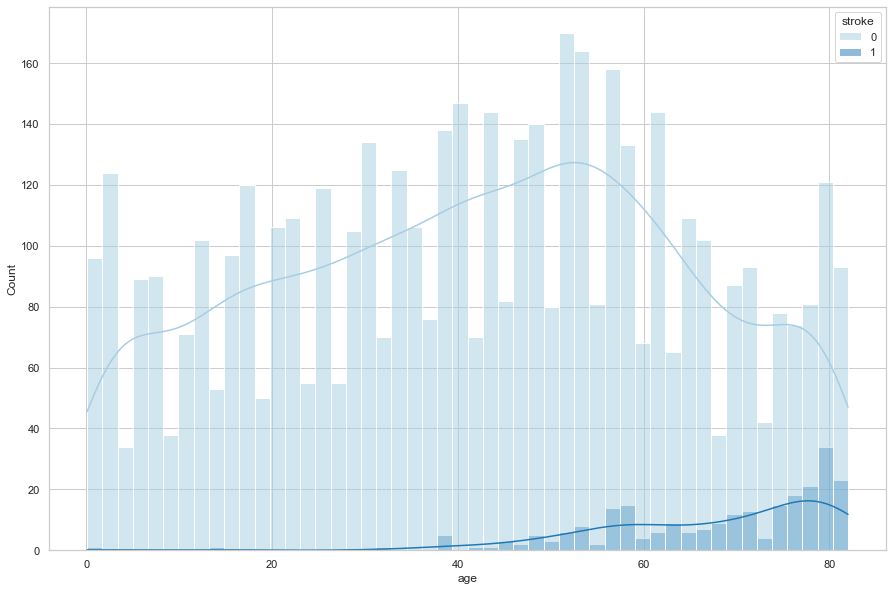

In [45]:
plt.figure(figsize=(15,10))
sns.histplot(data=df, x='age', hue='stroke', bins=50, kde=True, palette='Paired')

As expected, the prevalence of stroke = 1 outcomes increases with age. Stroke prevalence also seems tied to population density, with respect to each bin/age group. For example, the uptick in stroke = 1 outcomes just prior to age 40 appears to have some relationship with the high population density within that age group. 

We may want to consider re-plotting this with a uniform distribution of age. 

Or--just plotting this data again after performing the SMOTE analysis, as that should have a similar effect.

In [52]:
# Total stroke instances in patients less than 50 years old
len(df[(df['stroke'] == 1) & (df['age']<50)])

20

In [53]:
# Total stroke instances in patients aged 50 and over
len(df[(df['stroke'] == 1) & (df['age']>=50)])

229

<AxesSubplot:xlabel='age'>

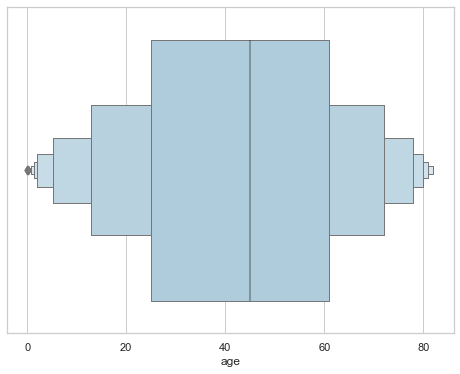

In [100]:
plt.figure(figsize=(8,6))
sns.boxenplot(x='age',data=df, palette='Paired')

<AxesSubplot:xlabel='work_type', ylabel='count'>

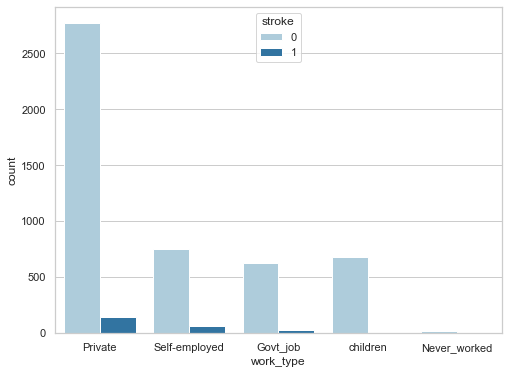

In [94]:
plt.figure(figsize=(8,6))
sns.countplot(x='work_type', data=df, hue='stroke', palette='Paired')

In [80]:
df[df['stroke']==1]['work_type'].value_counts().plot(k)

Private          149
Self-employed     65
Govt_job          33
children           2
Name: work_type, dtype: int64

### Interesting!

There are no stroke victims in the "Never_worked" category, and only 2 in the "children" category. Out SMOTE analysis may increase the number of occurences in "children", but it won't populate the "Never_worked" category. Let's take a closer look at "Never_worked." I'm guessing that the majority of individuals under this classification are young. If so, we may have to worry about multicollinearity between 'age' and 'work_type'.

In [85]:
df[df.work_type == 'Never_worked'].describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,22.000000,22.000000,22.0,22.0,22.000000,22.000000,22.0
mean,38274.409091,16.181818,0.0,0.0,96.042727,25.545455,0.0
std,20166.419938,2.342899,0.0,0.0,28.697132,7.441757,0.0
min,11702.000000,13.000000,0.0,0.0,59.990000,14.600000,0.0
25%,19830.750000,14.250000,0.0,0.0,78.457500,20.975000,0.0
50%,36054.500000,16.000000,0.0,0.0,86.020000,23.150000,0.0
75%,57202.000000,17.000000,0.0,0.0,112.807500,28.350000,0.0
max,71966.000000,23.000000,0.0,0.0,161.280000,44.900000,0.0


Sure enough, the youngest is 13 and the oldest is 23. We'll keep this in mind as we move forward.

<AxesSubplot:xlabel='Residence_type', ylabel='count'>

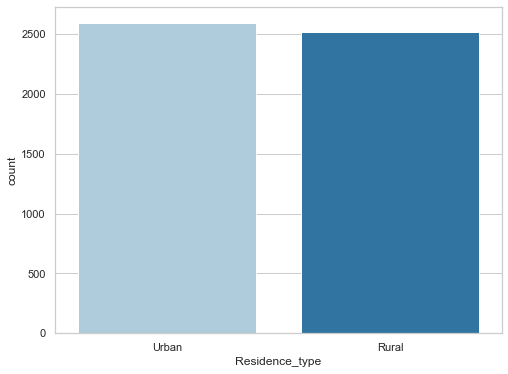

In [88]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Residence_type', palette='Paired')

<AxesSubplot:xlabel='ever_married', ylabel='count'>

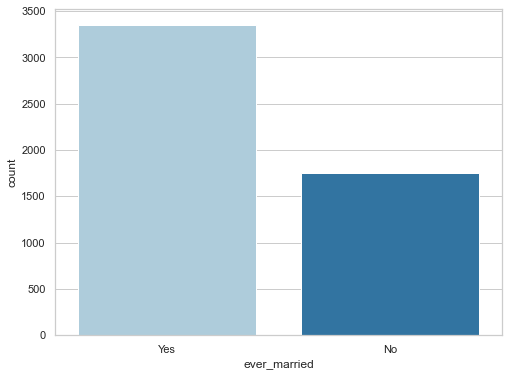

In [102]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='ever_married',palette='Paired')

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

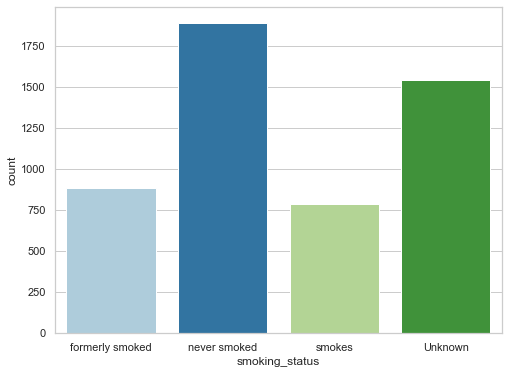

In [105]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='smoking_status', palette='Paired')

In [22]:
len(df[df['smoking_status'] == 'Unknown'])/len(df)*100

30.21526418786693

30% of the smoking_status feature is missing. We are going to need to take a few different approaches and compare their results. 

* Use a KNN imputer to classify the "Unknown" values
* Drop rows that have an "Unknown" smoking_status
* Drop the smoking_status feature


<AxesSubplot:xlabel='bmi', ylabel='Count'>

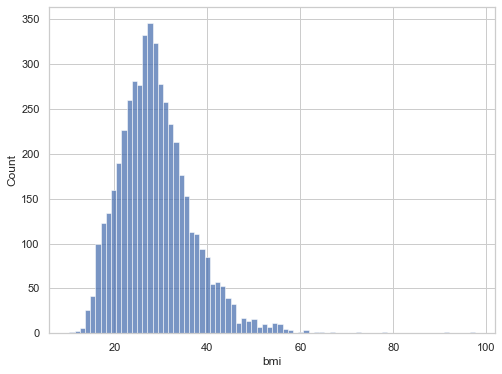

In [109]:
plt.figure(figsize=(8,6))
sns.histplot(x='bmi', data=df, palette='Paired')

In [110]:
df.bmi.isna().sum()

201

In [128]:
df.bmi.isna().sum()/len(df) * 100

3.9334637964774952

Only 3.93% of bmi values are missing, so we'll impute the mean for this feature.

In [113]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

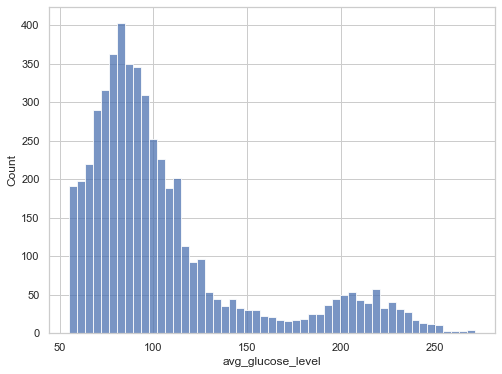

In [116]:
plt.figure(figsize=(8,6))
sns.histplot(x='avg_glucose_level', data=df, palette='Paired')

<AxesSubplot:xlabel='avg_glucose_level'>

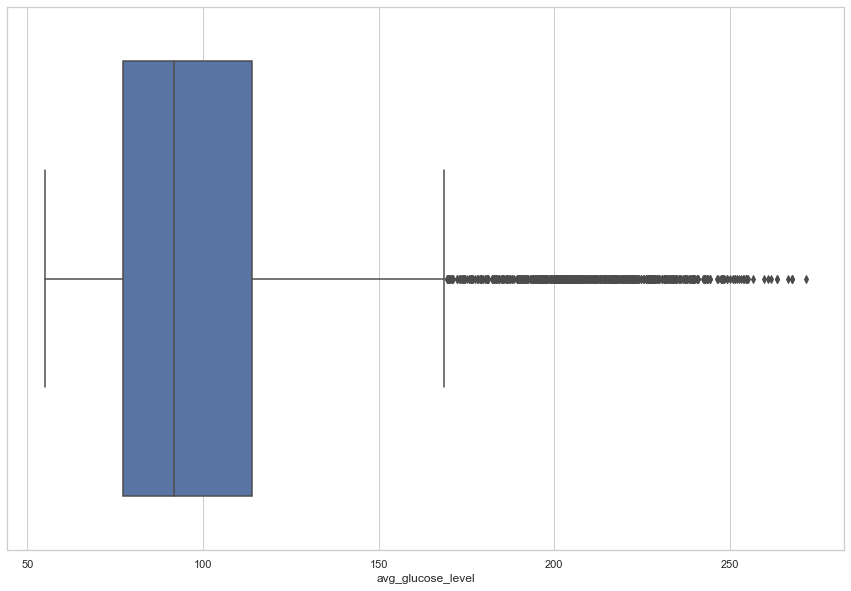

In [119]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df, x='avg_glucose_level')

avg_glucose_level appears to have a lot of outliers. Let's figure out just how many outliers it has.


In [27]:
len(df[df['avg_glucose_level'] > df['avg_glucose_level'].quantile(0.99)])

52

In [120]:
outliers = df[(np.abs(df.avg_glucose_level - df.avg_glucose_level.mean()) > (3*df.avg_glucose_level.std()))]

In [29]:
len(outliers)

49

There are 52 individuals above the 99th percentile and 49 individuals that are more than 3 standard deviations above the mean.

We know that stroke=1 is true for only ~5% of the dataset so before we consider removing the anomalous individuals, let's take note of the effect of an exceptionally high avg_glucose_level on the target variable. 

Text(0.5, 1.0, 'Stroke Outcomes w/ Respect to Anomolous Glucose Levels')

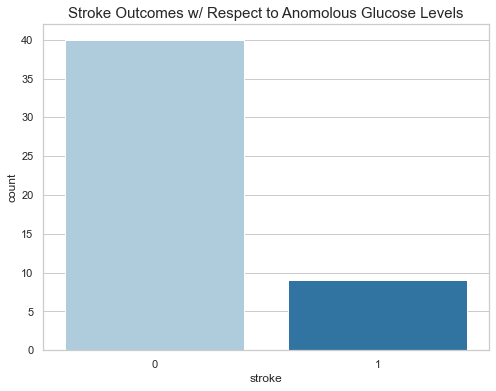

In [125]:
plt.figure(figsize=(8,6))
sns.countplot(data=outliers, x='stroke', palette='Paired')

plt.title('Stroke Outcomes w/ Respect to Anomolous Glucose Levels', fontsize='15')

In [130]:
# Percentage of glucose outlier cases where stroke = 1
len(outliers[outliers['stroke']==1]) / len(outliers[outliers['stroke']==0]) * 100

22.5

In [131]:
# Percentage of stroke = 1 instances where avg_glucose is an outlier
(len(outliers[outliers['stroke']==1])/len(df[df['stroke']==1])) * 100

3.614457831325301

### Looks like these aren't outliers, rather we have a wide distribution

An exceptionally high avg_glucose_level does seem to have an effect on stroke outcome. We can see that 22.5% of the individuals with an avg_glucose_level more than 3 standard deviations above the mean have had a stroke, accounting for 3.61% of stroke=1 instances.

We should still evaluate performance under the following conditions:
- Run one model with the outliers using standardization
- Run one model without the outliers using normalization


In [33]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Text(0.5, 1.0, 'Prevalence of Hypertension')

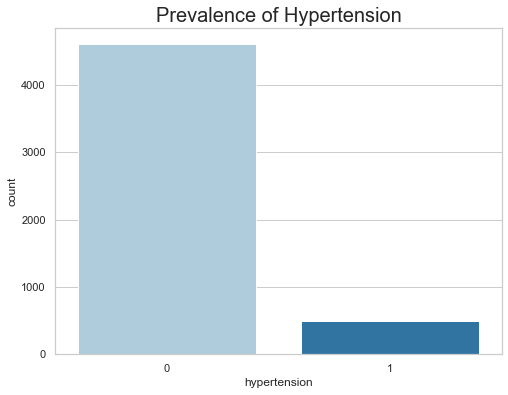

In [139]:
plt.figure(figsize=(8,6))
sns.countplot(x='hypertension', data=df, palette='Paired')
plt.title('Prevalence of Hypertension', size=20)

Text(0.5, 1.0, 'Prevalence of Heart Disease')

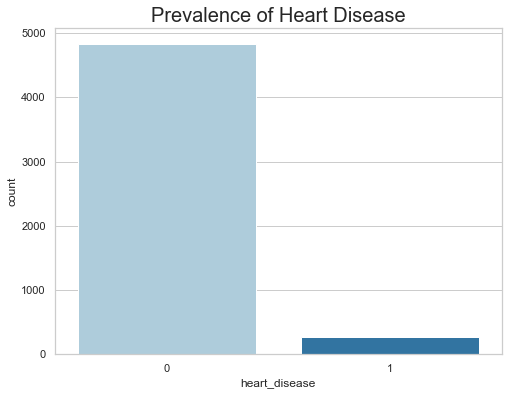

In [140]:
plt.figure(figsize=(8,6))
sns.countplot(x='heart_disease', data=df, palette='Paired')
plt.title('Prevalence of Heart Disease', size=20)

The previous 2 graphs further support the use of SMOTE analysis. 

Text(0.5, 1.0, 'Marriage Distribution')

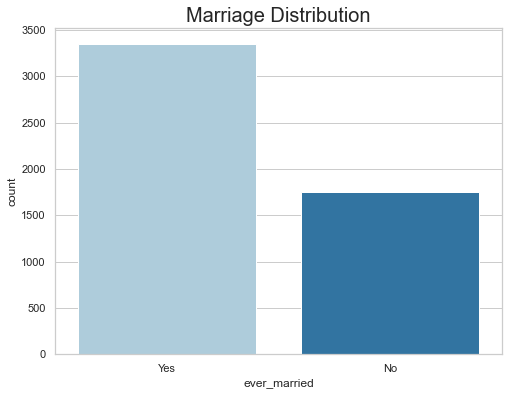

In [141]:
plt.figure(figsize=(8,6))
sns.countplot(x='ever_married', data=df, palette='Paired')
plt.title('Marriage Distribution', size=20)

# Feature Engineering

In [4]:
df.drop('id', axis=1, inplace=True)

In [5]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [7]:
# It would be good to make a custom function (feature union?) that converts any gender input other than
# 'Male' or 'Female' to the the most common gender

In [8]:
df = df[df.gender != 'Other']

In [9]:
df['smoking_status'] = df.smoking_status.apply(lambda x: np.nan if x=='Unknown' else x)

In [10]:
###
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

In [11]:
# probably want to do this after all other transformations, because we want to OneHotEncode
### FIRST TRY WITH SIMPLE IMPUTER
df = df.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

imputer = KNNImputer(n_neighbors=1)
imputer.fit_transform(df)

array([[  1.,  88.,   0., ..., 239.,   0.,   1.],
       [  0.,  82.,   0., ..., 190.,   1.,   1.],
       [  1., 101.,   0., ..., 198.,   1.,   1.],
       ...,
       [  0.,  56.,   0., ..., 179.,   1.,   0.],
       [  1.,  72.,   0., ..., 129.,   0.,   0.],
       [  0.,  65.,   0., ..., 135.,   1.,   0.]])

In [12]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,88,0,1,1,2,1,3849,239.0,0.0,1
1,0,82,0,0,1,3,0,3587,NaN,1.0,1
2,1,101,0,1,1,2,0,2483,198.0,1.0,1
3,0,70,0,0,1,2,1,3384,217.0,2.0,1
4,0,100,1,0,1,3,0,3393,113.0,1.0,1


In [42]:
# Taken from: https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa
#instantiate both packages to use
encoder = OneHotEncoder()
imputer = KNNImputer()
# create a list of categorical columns to iterate over
cat_cols = ['gender','ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [44]:
def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(df[columns])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = df.drop(labels='stroke', axis=1)

In [12]:
y = df['stroke']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### BMI

We need to rid the data of NaNs before we can make smoking predictions. Let's replace the NaNs from BMI with the mean value of BMI. 

Note: could also have used sklearn's IterativeImputer which uses regression to determine NaNs. Keep in mind that sklearn imputers will replace ALL NaN's in the df, so only use the imputer against columns that you want filled that way.

In [370]:
# df['new_smoke_status'].value_counts()

never smoked       1892
formerly smoked     884
smokes              789
Name: new_smoke_status, dtype: int64

We are going to use sklearn's KNNImputer for determining the NaNs in new_smoke_status, so we will need to encode the variables and perform standardization first.

### Pipeline
We will need to encode work_type prior to imputing new_smoke_status.
However, sklearn imputers 

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [15]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4540,Male,4.0,0,0,No,children,Urban,87.00,19.0,NaN
3379,Female,41.0,0,0,Yes,Private,Urban,74.85,24.8,formerly smoked
479,Male,54.0,1,0,Yes,Private,Rural,198.69,NaN,smokes
3683,Male,80.0,0,1,Yes,Self-employed,Rural,95.49,31.6,NaN
2997,Male,71.0,0,1,Yes,Private,Urban,204.98,NaN,formerly smoked


In [22]:
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [23]:
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [24]:
# Looks like OneHotEncoder doesn't work on 

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(drop=True))])

In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [26]:
num_pipe = Pipeline([
    #('num_impute', SimpleImputer(strategy='mean')),
    ('iimputer', IterativeImputer()),
    ('scaler', StandardScaler())])

In [27]:
data_prep = ColumnTransformer([('cat', cat_pipe, cat_cols),
                                    ('num', num_pipe, num_cols)])

In [ ]:
full_pipeline = Pipeline([])

In [32]:
smoking_imputer.fit(X_train)

ValueError: Input contains NaN

In [11]:
cat_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          5110 non-null   object
 1   ever_married    5110 non-null   object
 2   work_type       5110 non-null   object
 3   Residence_type  5110 non-null   object
 4   smoking_status  5110 non-null   object
dtypes: object(5)
memory usage: 199.7+ KB


In [12]:
cat_feats.head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [13]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [14]:
num_feats = df.drop(labels=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis=1)

### NOTE: Have to either impute prior to encoding a column, or encode on dropped cols

## Pipeline Notes:
- Pipelines are containers of steps
    - __Transformer__
        - transform(X,[y])
            - Applies transformations on X
        - fit(X,[y])
            - Applies fit logic on X_
            
        _Re-use your custom transformers across any projects!_
    - __Estimator__
        - fit(X,[y])
            - Fits the model object on the data
        - predict(x)
            - Predict class labels for samples in X 
    - __Pipeline__
        - transform(X,[y])
            - Call fit then transform each step contained inside
        - predict(X)
            - Call transform on each step __then predict on the final step__
            
        _Initialized by passing a list of tuples in the form: (name,transformer)_
    
    - __FeatureUnion__
- Pipelines are used to package a workflow and fit model into a single object

### Model Development Process
- Feature Engineering
- Model Selection
- Hyperparameter Optimization
- Cross Validation
- Publish


In [21]:
num_pipeln = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scalar', StandardScaler()),
])

In [22]:
from sklearn.compose import ColumnTransformer

In [23]:
num_names = list(num_feats)
cat_names = list(cat_feats)

In [24]:
my_pipeln = ColumnTransformer([
    ("nums", num_pipeln, num_names),
    ("cats", OneHotEncoder(), cat_names)
])

In [25]:
df_ready = my_pipeln.fit_transform(df)

In [26]:
df_ready

array([[ 1.05143428, -0.32860186,  4.18503199, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.78607007, -0.32860186, -0.2389468 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.62639008, -0.32860186,  4.18503199, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.36384151, -0.32860186, -0.2389468 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.34379639, -0.32860186, -0.2389468 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.03420481, -0.32860186, -0.2389468 , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
num_pip = Pipeline([
    ('std_scaler', StandardScaler()),
    ('imputer', KNNImputer(missing_values='NaN', n_neighbors=3))
])

In [236]:
df2 = df.drop(['stroke', 'id', 'bmi', 'smoking_status'], axis=1)

In [237]:
from sklearn.impute import KNNImputer